In [1]:
import numpy as np
import operator
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import EngFormatter
from matplotlib.patches import Rectangle
import scipy.signal as sp
from quantiphy import Quantity
rc('font',family='serif')
formatter0 = EngFormatter(unit='Hz')

In [2]:
def zoomingBox(ax1, roi, ax2, color='red', linewidth=2):
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2],**dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)]) ))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)]))

The code below opens the file and extracts the data from the data.txt file and places it into the interleaved_data variable

In [3]:
file = open("data.bin", "r")
interleaved_data = np.fromfile(file, np.uint8)
file.close()

# Code from practical 1:
This data is then extracted and normalized

In [4]:
I_data_raw = interleaved_data[0:len(interleaved_data):2]
Q_data_raw = interleaved_data[1:len(interleaved_data):2]

I_samples = (I_data_raw-127.5)/127.5
Q_samples = (Q_data_raw-127.5)/127.5

complex_data = I_samples + 1j*Q_samples
complex_data_bins = np.arange(0,len(complex_data),1)

This defines the start and stop bins and splices the data into DATA_I and DATA_Q. This data is then normalized and placed into the variable DATA_signal

In [5]:
start = 104956
end = 131597
DATA_I = I_samples[start:end]
DATA_Q = Q_samples[start:end]
DATA_mag = np.abs(complex_data)[start:end]
DATA_I = DATA_I / DATA_mag.max()
DATA_Q = DATA_Q / DATA_mag.max()
DATA_signal = DATA_I + 1j*DATA_Q

The code in the cell below plot the magnitude of the spliced data, this done using the abs() function from numpy. This is done to veryify that the correct data is being spliced.

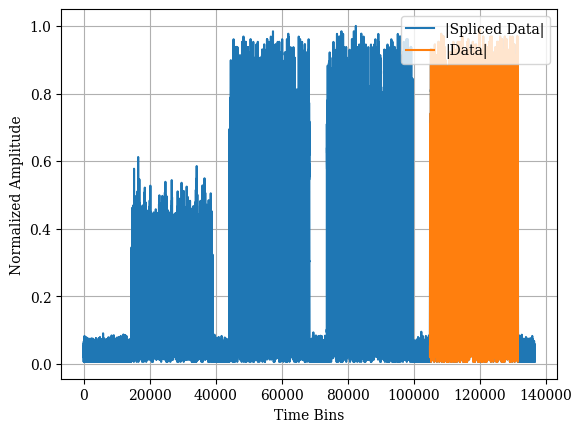

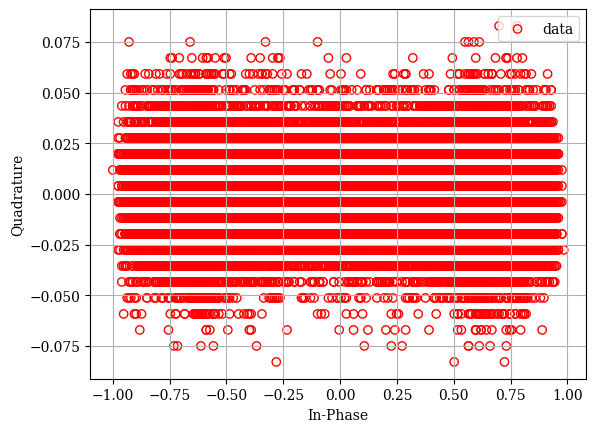

In [6]:
plt.figure(1)
plt.plot(complex_data_bins,np.abs(complex_data),label = '|Spliced Data|')
plt.plot(complex_data_bins[start-20:end+20],np.abs(complex_data[start-20:end+20]),label = '|Data|')
plt.xlabel("Time Bins")
plt.ylabel("Normalized Amplitude")
plt.legend(loc='upper right')
plt.grid()
plt.show()

plt.figure(2)
plt.scatter(np.real(DATA_signal), np.imag(DATA_signal),facecolors='none', edgecolors='r',label='data') 
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.legend(loc='upper right')
plt.grid()
plt.show()

Time and frequency arrays are created from knowing that the carrier freqency is 1.3 GHz.

In [7]:
fs = 2.4E6 #Carrier frequency of SDR
dt = 1/(fs) #Timestep between samples 
freq = np.fft.fftfreq(len(DATA_signal),dt)
bins=np.arange(0,len(DATA_signal),1)
t=bins*dt

The code found below plots the scatter plot of the data with the freqency offset that is corrected.

Since it is given that the first 10 symbols of the signal are used for syncroization and contain no information it is possible to do a corse frequency offset corrrection by obtaining the median between the phase differnece of these samples

$$ \Delta\Phi = \Phi_{2} - \Phi_{1}$$
since we know that the $\Delta\Phi$ is related to $\Delta f$ by the following equation,
$$\Delta f = \frac{median(\Delta\Phi)}{2 \pi \Delta t} $$


In [8]:
DATA_SIGNAL_O = np.fft.fft(DATA_signal)
DATA_MAG_O = 10*np.log10(np.abs(DATA_SIGNAL_O))
Δ_Φ = np.diff(np.unwrap((np.angle(DATA_signal[2:227]))))
Δ_f = np.median(Δ_Φ)  / (np.pi*2*dt)
print(" Corse Frequency Offset:",Quantity(Δ_f,'Hz'))

 Corse Frequency Offset: 29.475 Hz


Once one has aquired $\Delta f$ in order to correct the freqency offset one needs to multiply by a complex sinusoide in order to correct the offset this is done acording to the equation below

$$ s(t) \cdot e^{j(\omega_{c}+\omega_{o})\cdot t} \cdot e^{-j\omega_{o}} $$

where $\omega_{o}$ is the offset and $\omega_{c}$ is the carrier thus the following result is obtained

$$ s(t) \cdot e^{j(\omega_{c}+\omega_{o} - \omega_{o})\cdot t} $$

$$ s(t) \cdot e^{j(\omega_{c})t} $$


In [9]:
DATA_signal = DATA_signal*(np.cos(2*np.pi*(-1*Δ_f)*t) + 
                           1j*np.sin(2*np.pi*(-1*Δ_f)*t))

The code in the cell below computes the FFT of the now freqency corrected data signal.

In [10]:
DATA_SIGNAL = np.fft.fft(DATA_signal)
DATA_MAG = 10*np.log10(np.abs(DATA_SIGNAL))
DATA_SIGNAL_ABS = np.fft.fft(np.abs(DATA_signal))
DATA_MAG_ABS = 10*np.log10(np.abs(DATA_SIGNAL_ABS))
DATA_SIGNAL_Φ = np.angle(DATA_SIGNAL_ABS)

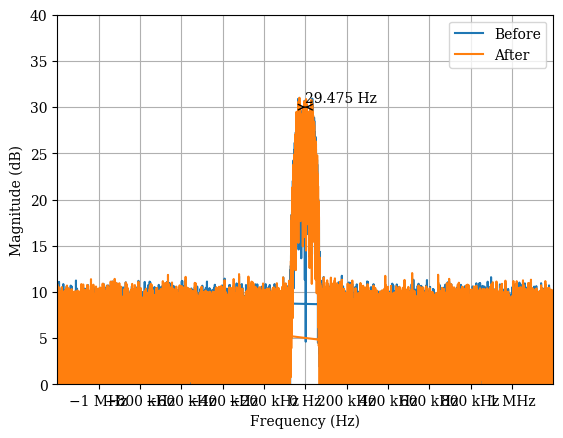

In [11]:
freq_tick = np.arange(-1E8,1E8,200E3)

fig2, ax = plt.subplots(1, 1)
ax.xaxis.set_major_formatter(formatter0)
ax.set_xticks(freq_tick)

ax.plot(freq,DATA_MAG_O,label="Before")
ax.plot(freq,DATA_MAG,label="After")

ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude (dB)")

ax.set_ylim(0,40)
ax.set_xlim(min(freq),max(freq))

ax.annotate("", xy=(0, 30), xycoords='data',xytext=(Δ_f,30), textcoords='data',arrowprops=dict(arrowstyle="<->",connectionstyle="arc3"),)
ax.annotate(Quantity(Δ_f,'Hz'),xy=(0,0), xycoords='data',xytext=(Δ_f/3,30.5), textcoords='data')
ax.legend(loc='upper right')
ax.grid()

The recived data now needs to be downsampled this means that the data only contains symbols at certain increments and thus we need to obtain the frequency and phase of the ogrinal sampling clock in order to reproduce the the sampling clock and syncronise with the symbols.
<br>
This is done by taking the DFT|data| by taking the DFT of the absolute one removes the frequency and phase offset.
<br>
Since it is provided that the system has a symbol rate of around 100,000 symbols per second then a large oberservable spike should accour at around that point.
<br>
*[Note] It is not at exactly 100 kHz because there is error in the local oscilator in the SDR, therefore it does not match up exactly

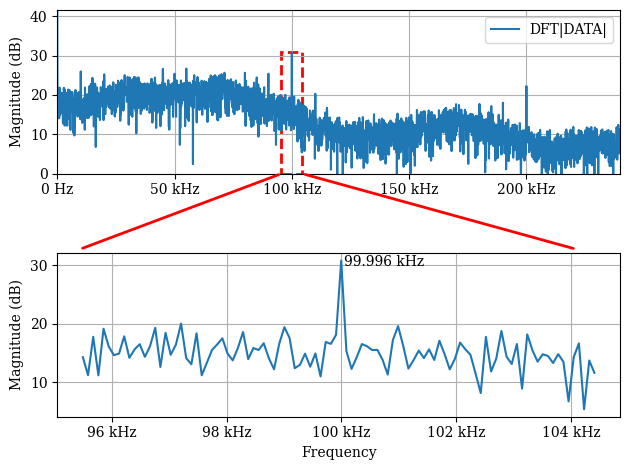

In [12]:
Index_max = 800+(DATA_MAG_ABS[800:2500].argmax())
freq_tick = np.arange(0,600E3,50E3)
  
fig3, (ax1, ax2) = plt.subplots(2, 1,tight_layout=True)
ax1.plot(freq[:len(freq)//10],DATA_MAG_ABS[:len(freq)//10],label='DFT|DATA|')
ax1.xaxis.set_major_formatter(formatter0)
ax1.set_xticks(freq_tick)
ax1.set_ylabel("Magnitude (dB)")
ax1.set_ylim(0,max(DATA_MAG_ABS))
ax1.set_xlim(0,max(freq[len(freq)//10-1:len(freq)//10]))
ax1.legend(loc='upper right')
ax1.grid()
ax2.xaxis.set_major_formatter(formatter0)
ax2.plot(freq[Index_max-50:Index_max+50],DATA_MAG_ABS[Index_max-50:Index_max+50])
ax2.annotate(Quantity(freq[Index_max],'Hz'),xy=(freq[Index_max],DATA_MAG_ABS[Index_max]-1), xycoords='data',xytext=(freq[Index_max]+50,DATA_MAG_ABS[Index_max]-1), textcoords='data')
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Magnitude (dB)")
ax2.grid()
zoomingBox(ax1, [freq[Index_max-50],freq[Index_max+50],0,DATA_MAG_ABS[Index_max]], ax2)

Once the frequency spike(which represents the data) is located one may also optain the $\Phi_{clock}$ by the following equation
$$\Phi_{clock} = tan^{-1}(Q/I)$$ where Q and I are the compents at the freqency spike.

In [13]:
f_clk=freq[Index_max]
freq_δ = np.abs(freq[0]-freq[1])/2
#Now need to obtain the phase of the clock.
# I did this by using the index function which searches the array and returns the bin where that value is located
for i, j in enumerate(freq):
    if (f_clk-freq_δ) < j < (f_clk+freq_δ):
            freq_bin=(i)
Φ = DATA_SIGNAL_Φ[freq_bin]
f = freq[freq_bin]
print('Clock Frequency:',Quantity(f,'Hz'))
print('Φ:',Quantity(Φ,'rad'))

Clock Frequency: 99.996 kHz
Φ: 930.26 mrad


In [14]:
ω = 2 * np.pi * f
NCO = np.cos((ω*t)+Φ) + 1j*np.sin((ω*t)+Φ)
NCO = NCO * (0.6)
global peak_bins 
peak_bins = sp.find_peaks(np.real(NCO))
symbol_data = np.interp(peak_bins[0],bins,DATA_signal)
sym_max = np.abs(symbol_data).max()
global norm_data
norm_data = np.real(symbol_data)/sym_max + 1j*np.imag(symbol_data)/sym_max

The functions below plot the Conseltation diagram for the down sampled date as well as the clock cosine signal, with 10 peaks to corfrim the correct sampling rate is obtained.

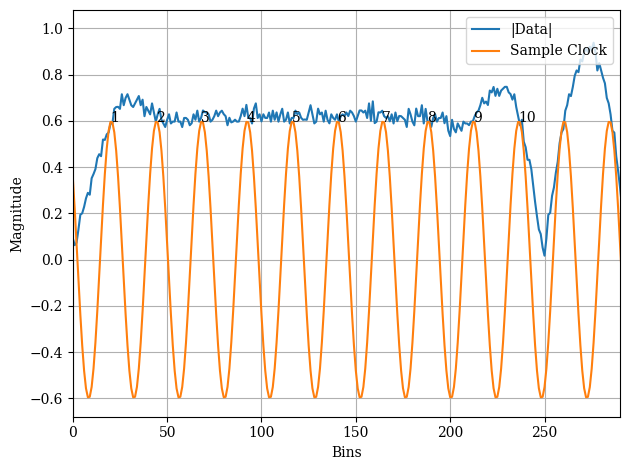

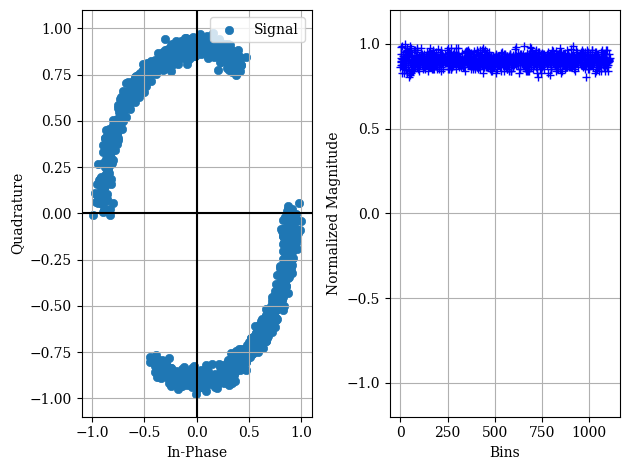

In [15]:
freq_tick = np.arange(-1E8,1E8,200E3)

fig4, ax = plt.subplots(1, 1, tight_layout=True)
ax.plot(bins,np.abs(DATA_signal),label="|Data|")
ax.plot(bins,np.real(NCO),label="Sample Clock")
ax.set_xlabel("Bins")
ax.set_ylabel("Magnitude")
ax.set_xlim(0,290)
for i in range(10):
    b = peak_bins[0][i]
    ax.annotate((i+1),(b,np.real(NCO[b])))
ax.legend(loc='upper right')
ax.grid()

fig5, (ax1, ax2) = plt.subplots(1, 2,tight_layout=True)
ax1.scatter(np.real(norm_data),np.imag(norm_data) ,linewidths=0.5,label='Signal')
ax1.set_xlabel("In-Phase")
ax1.set_ylabel("Quadrature")
ax1.set_xlim(-1.1,1.1)
ax1.set_ylim(-1.1,1.1)
ax1.axhline(y=0,c='k')
ax1.axvline(x=0,c='k')
ax1.legend(loc='upper right')
ax1.grid()

ax2.plot(np.abs(norm_data),'b+')
ax2.set_xlabel("Bins")
ax2.set_ylim(-1.2,1.2)
ax2.set_ylabel("Normalized Magnitude")
ax2.grid()

# code from practical 2:
Below is code from a practical 2 which implemnts a 'smart' phase lock loop
<br>
This is done by first synconusing the data with the first 10 samples as they only contain the carrier signal.
<br>
Once this synconization has been completed the phase error is calcualted and added to an on going error variable.
<br>
This vaiable is used to correct the phase by multiplying the next sample point with this error then computing the differnece and updating the error.


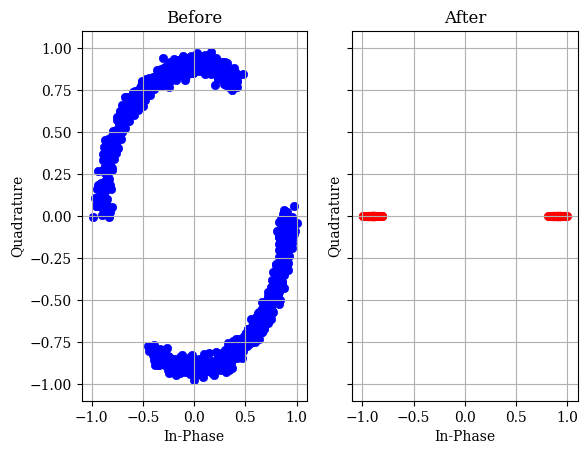

In [16]:
sd_after=[]
p0 = 1 + 1j*0
ΔΦ = 0
Φ_e = 0

Φ_error = []
Δ_Φ = []
for i in range (len(norm_data)):
    sd_after.append(norm_data[i])
    if i == 0:
        ΔΦ = np.angle(sd_after[i]*np.conj(p0))
        Φ_e += ΔΦ
    else:
        ΔΦ = np.angle(norm_data[i]*np.conj(norm_data[i-1]))
        if (np.pi/4) < np.abs(ΔΦ):
            Φ_e += (ΔΦ + np.pi)
        else:
            Φ_e += ΔΦ
    sd_after[i] = sd_after[i] * np.e**(-1j*Φ_e)
    Φ_error.append(Φ_e)
    Δ_Φ.append(ΔΦ)  

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(np.real(norm_data),np.imag(norm_data) ,linewidths=0.5,facecolors='b', edgecolors='b')
ax1.set_xlabel("In-Phase") 
ax1.set_ylabel("Quadrature")
ax1.set_title("Before")
ax1.set_xlim(-1.1,1.1)
ax1.set_ylim(-1.1,1.1)
ax1.grid()
ax2.scatter(np.real(sd_after),np.imag(sd_after) ,linewidths=0.5,facecolors='r', edgecolors='r')
ax2.set_xlabel("In-Phase") 
ax2.set_ylabel("Quadrature")
ax2.set_title("After")
ax2.set_xlim(-1.1,1.1)
ax2.set_ylim(-1.1,1.1)
ax2.grid()
plt.show()

The code below extracts the data from the phase differnce between samples

 $$  Data_{[n]} =   \left\{
\begin{array}{ll}
      100 < \Delta \Phi < 260 &: 1 \\
      else &: 0 \\
\end{array} 
\right.  $$

The data array is append acording to the above piecewise function.

In [17]:
Δ_Φ = np.abs(np.diff((np.angle(sd_after,deg='True'))))
data=[]
for i in range(len(Δ_Φ)):
    if 100 < Δ_Φ[i] < 260:
        data.append(1)
    else:
        data.append(0)
data = data[9:]

# Prac 3 code

In [18]:
S = np.matrix([[0,0,0],
              [1,0,0],
              [0,1,0],
              [1,1,0],
              [0,0,1],
              [1,0,1],
              [0,1,1],
              [1,1,1]])

Out = np.matrix([[0,0,0,0,0],
                 [0,0,0,0,0],
                 [0,0,0,0,0],
                 [0,0,0,0,0],
                 [0,0,0,0,0],
                 [0,0,0,0,0],
                 [0,0,0,0,0],
                 [0,0,0,0,0]])
for i in range(8):
    print('Current   Input     Next      Output')
    S2 = S[i,0]
    for j in range(4):
        if (j==0):
            S1 = 0
            S0 = 0
        if (j==1):
            S1 = 0
            S0 = 1
        if (j==2):
            S1 = 1
            S0 = 0
        if (j==3):
            S1 = 1
            S0 = 1
        Out[i,4] = np.mod((S2^S1^S0),2)
        Out[i,3] = np.mod((S2^S1),2)
        Out[i,2] = np.mod((S1^S0),2)
        Out[i,1] = np.mod((S2^S0),2)
        Out[i,0] = np.mod((S1),2)
        print('',S[i,2],S[i,1],S[i,0],' : ',S1,S0,' : ',S2,S1,S0,' : ',Out[i,4],Out[i,3],Out[i,2],Out[i,1],Out[i,0])
    print(' ')

Current   Input     Next      Output
 0 0 0  :  0 0  :  0 0 0  :  0 0 0 0 0
 0 0 0  :  0 1  :  0 0 1  :  1 0 1 1 0
 0 0 0  :  1 0  :  0 1 0  :  1 1 1 0 1
 0 0 0  :  1 1  :  0 1 1  :  0 1 0 1 1
 
Current   Input     Next      Output
 0 0 1  :  0 0  :  1 0 0  :  1 1 0 1 0
 0 0 1  :  0 1  :  1 0 1  :  0 1 1 0 0
 0 0 1  :  1 0  :  1 1 0  :  0 0 1 1 1
 0 0 1  :  1 1  :  1 1 1  :  1 0 0 0 1
 
Current   Input     Next      Output
 0 1 0  :  0 0  :  0 0 0  :  0 0 0 0 0
 0 1 0  :  0 1  :  0 0 1  :  1 0 1 1 0
 0 1 0  :  1 0  :  0 1 0  :  1 1 1 0 1
 0 1 0  :  1 1  :  0 1 1  :  0 1 0 1 1
 
Current   Input     Next      Output
 0 1 1  :  0 0  :  1 0 0  :  1 1 0 1 0
 0 1 1  :  0 1  :  1 0 1  :  0 1 1 0 0
 0 1 1  :  1 0  :  1 1 0  :  0 0 1 1 1
 0 1 1  :  1 1  :  1 1 1  :  1 0 0 0 1
 
Current   Input     Next      Output
 1 0 0  :  0 0  :  0 0 0  :  0 0 0 0 0
 1 0 0  :  0 1  :  0 0 1  :  1 0 1 1 0
 1 0 0  :  1 0  :  0 1 0  :  1 1 1 0 1
 1 0 0  :  1 1  :  0 1 1  :  0 1 0 1 1
 
Current   Input     Next 

In [19]:
D = np.zeros((32, 7),dtype = 'int')
count=0
for i in range(8):
    S2 = S[i,0]
    for j in range(4):
        if (j==0):
            S1 = 0
            S0 = 0
        if (j==1):
            S1 = 0
            S0 = 1
        if (j==2):
            S1 = 1
            S0 = 0
        if (j==3):
            S1 = 1
            S0 = 1
        Y4= np.mod((S2^S1^S0),2)
        Y3 = np.mod((S2^S1),2)
        Y2 = np.mod((S1^S0),2)
        Y1 = np.mod((S2^S0),2)
        Y0 = np.mod((S1),2)
        NS = S2*(4) + S1*(2) + S0*(1)
        D[count,0] = i
        D[count,1] = NS
        D[count,2] = Y4
        D[count,3] = Y3
        D[count,4] = Y2
        D[count,5] = Y1
        D[count,6] = Y0
        count += 1

In [20]:
NOstates = 8
NOsample = 5

TS = np.zeros((NOstates,NOsample),dtype = 'int')
#print(Trellis_State)

TP = np.ones((NOstates,NOsample),dtype = 'int') *9

TH = np.zeros((NOstates,NOsample),dtype = 'int')
#print(Trellis_Hamming)


def HanningDistance(S1,S2):
    return sum(map(operator.xor,S1,S2)) #Calculates the Hanning Distnace of two data arrays

def FetchData(j):
    R = data[(j*5):(j+1)*5]
    return R                            #Returns the 6 bits of data at the integer location j

def StateInfo(CS):
    index = np.where(D[:,0] == CS)[0]
    return index                        #Returns the index of the CS in the State Transision Matrix D

def Expected(index):
    NS = D[index,1] 
    Expected = D[index,2:7] 
    return  NS,Expected                 #Returns the expected data  and the NS from matrix D according to an index

def NodeCheck():
    pass                                #Check if two brances meet at the same node and removes the branch with largest Hamming Weight




In [21]:
HWeight = np.ones((32, 1)) * np.inf
Best = np.ones((8, 1)) * 0
temp = np.ones((4, 1)) * 0
Path = np.ones((8, 1)) * np.inf
Path[0,0] = 0

for i in range(4):
    HWeight[i] = 0

R = FetchData(0)


for i in range(32):
    HWeight[i] += HanningDistance(D[i,2:],R)


for i in range(8):    
    Best[i] = np.amin(HWeight[i::8,0] + Best[i])
    HWeight[i::8,0] = Best[i]
Path = np.append(Path, Best, axis=1)

R = FetchData(1)


P = np.zeros((32, 4))
count=0
for i in range(8):
    S2 = S[i,0]
    for j in range(4):
        if (j==0):
            X0 = 0
            X1 = 0
        if (j==1):
            X0 = 0
            X1 = 1
        if (j==2):
            X0 = 1
            X1 = 0
        if (j==3):
            X0 = 1
            X1 = 1
        S0 = X1
        S1 = X0
        Y0 = np.mod((S2^S1^S0),2)
        Y1 = np.mod((S2^S1),2)
        Y2 = np.mod((S1^S0),2)
        Y3 = np.mod((S2^S0),2)
        Y4 = np.mod((S1),2)
        NS = S2*(4) + S1*(2) + S0*(1)
        P[count,0] = i
        P[count,1] = NS
        P[count,2] = Path[i,1]
        P[count,3] = HanningDistance(D[count,2:],R)
        count += 1

for i in range (8):
    index = np.where(P[:,1] == i)
    for k in range(4):
        temp[k] = P[i,2] + P[i,3]
    Best[i] = np.amin(temp)
Path = np.append(Path, Best, axis=1)
    
R = FetchData(2)


P = np.zeros((32, 4))
count=0
for i in range(8):
    S2 = S[i,0]
    for j in range(4):
        if (j==0):
            X0 = 0
            X1 = 0
        if (j==1):
            X0 = 0
            X1 = 1
        if (j==2):
            X0 = 1
            X1 = 0
        if (j==3):
            X0 = 1
            X1 = 1
        S0 = X1
        S1 = X0
        Y0 = np.mod((S2^S1^S0),2)
        Y1 = np.mod((S2^S1),2)
        Y2 = np.mod((S1^S0),2)
        Y3 = np.mod((S2^S0),2)
        Y4 = np.mod((S1),2)
        NS = S2*(4) + S1*(2) + S0*(1)
        P[count,0] = i
        P[count,1] = NS
        P[count,2] = Path[i,2]
        P[count,3] = HanningDistance(D[count,2:],R)
        count += 1

for i in range (8):
    index = np.where(P[:,1] == i)
    for k in range(4):
        temp[k] = P[index[0][k],2] + P[index[0][k],3]

    Best[i] = np.amin(temp)
Path = np.append(Path, Best, axis=1)

for t in range(3,len(data)//5):
    R = FetchData(t)

    
    P = np.zeros((32, 4))
    count=0
    for i in range(8):
        S2 = S[i,0]
        for j in range(4):
            if (j==0):
                X0 = 0
                X1 = 0
            if (j==1):
                X0 = 0
                X1 = 1
            if (j==2):
                X0 = 1
                X1 = 0
            if (j==3):
                X0 = 1
                X1 = 1
            S0 = X1
            S1 = X0
            Y0 = np.mod((S2^S1^S0),2)
            Y1 = np.mod((S2^S1),2)
            Y2 = np.mod((S1^S0),2)
            Y3 = np.mod((S2^S0),2)
            Y4 = np.mod((S1),2)
            NS = S2*(4) + S1*(2) + S0*(1)
            P[count,0] = i
            P[count,1] = NS
            P[count,2] = Path[i,t]
            P[count,3] = HanningDistance(D[count,2:],R)
            count += 1
    
    for i in range (8):
        index = np.where(P[:,1] == i)
        for k in range(4):
            temp[k] = P[index[0][k],2] + P[index[0][k],3]
        Best[i] = np.amin(temp)
    Path = np.append(Path, Best, axis=1)

Route =[]
for i in range(1,219):
    Route.append(np.argmin(Path[:,i]))

corrected = []
for i in Route:
    if (i == 0):
        corrected.append('00')
    if (i == 1):
        corrected.append('01')
    if (i == 2):
        corrected.append('10')
    if (i == 3):
        corrected.append('11')
    if (i == 4):
        corrected.append('00')
    if (i == 5):
        corrected.append('01')
    if (i == 6):
        corrected.append('10')
    if (i == 7):
        corrected.append('11')
        
        

corrected = ''.join(corrected)
message = ""
for i in  range(0,53*8,8):
    temp_data = corrected[i:i + 8]
    decimal_data = int(temp_data, 2) 
    message = message + chr(decimal_data)
print(message)

^Teeckersð7ho take clacs mttendance avuôabsent-minde$
